In [1]:
import math
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import poppy as pp
import organized_functions1 as pr

%load_ext autoreload # reload 'autoreload'
%autoreload 2 # autonomously reload all import modules
%matplotlib inline # directly show images in the notebook


C:\Users\yiyan\.conda\envs\phase_retrieval_LFAST\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


ModuleNotFoundError: No module named "autoreload # reload 'autoreload'"

# Generate the pupil image

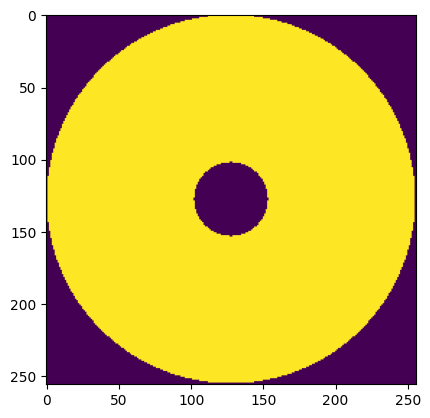

In [3]:
wavelength = 580e-9 # wavelength in meters
od_pupil = 0.3808 # outer pupil diameter in meters
id_pupil = 0.0762 # inner pupil diameter in meters
npix_pupil = 256 # sampling rate on a single side of the pupil

x = cp.linspace(-od_pupil / 2, od_pupil / 2, npix_pupil) # give a 1 x 512 vector in range [-d_pupil/2, d_pupil/2]
x, y = cp.meshgrid(x, x) # use 2 vectors to generate 2 mesh grids
r = cp.sqrt(x ** 2 + y ** 2) # radius

pupil = cp.ones_like(r) # create a matrix whose size and data format are similar to 'r' and value is 1
pupil[r >= od_pupil / 2] = 0 # update the pupil according to the positions obtained through 'r'
pupil[r <= id_pupil / 2] = 0

plt.imshow(pupil.get())
plt.show()


# Read the captured data


(21, 28, 28)
(21, 256, 256)
(21,)


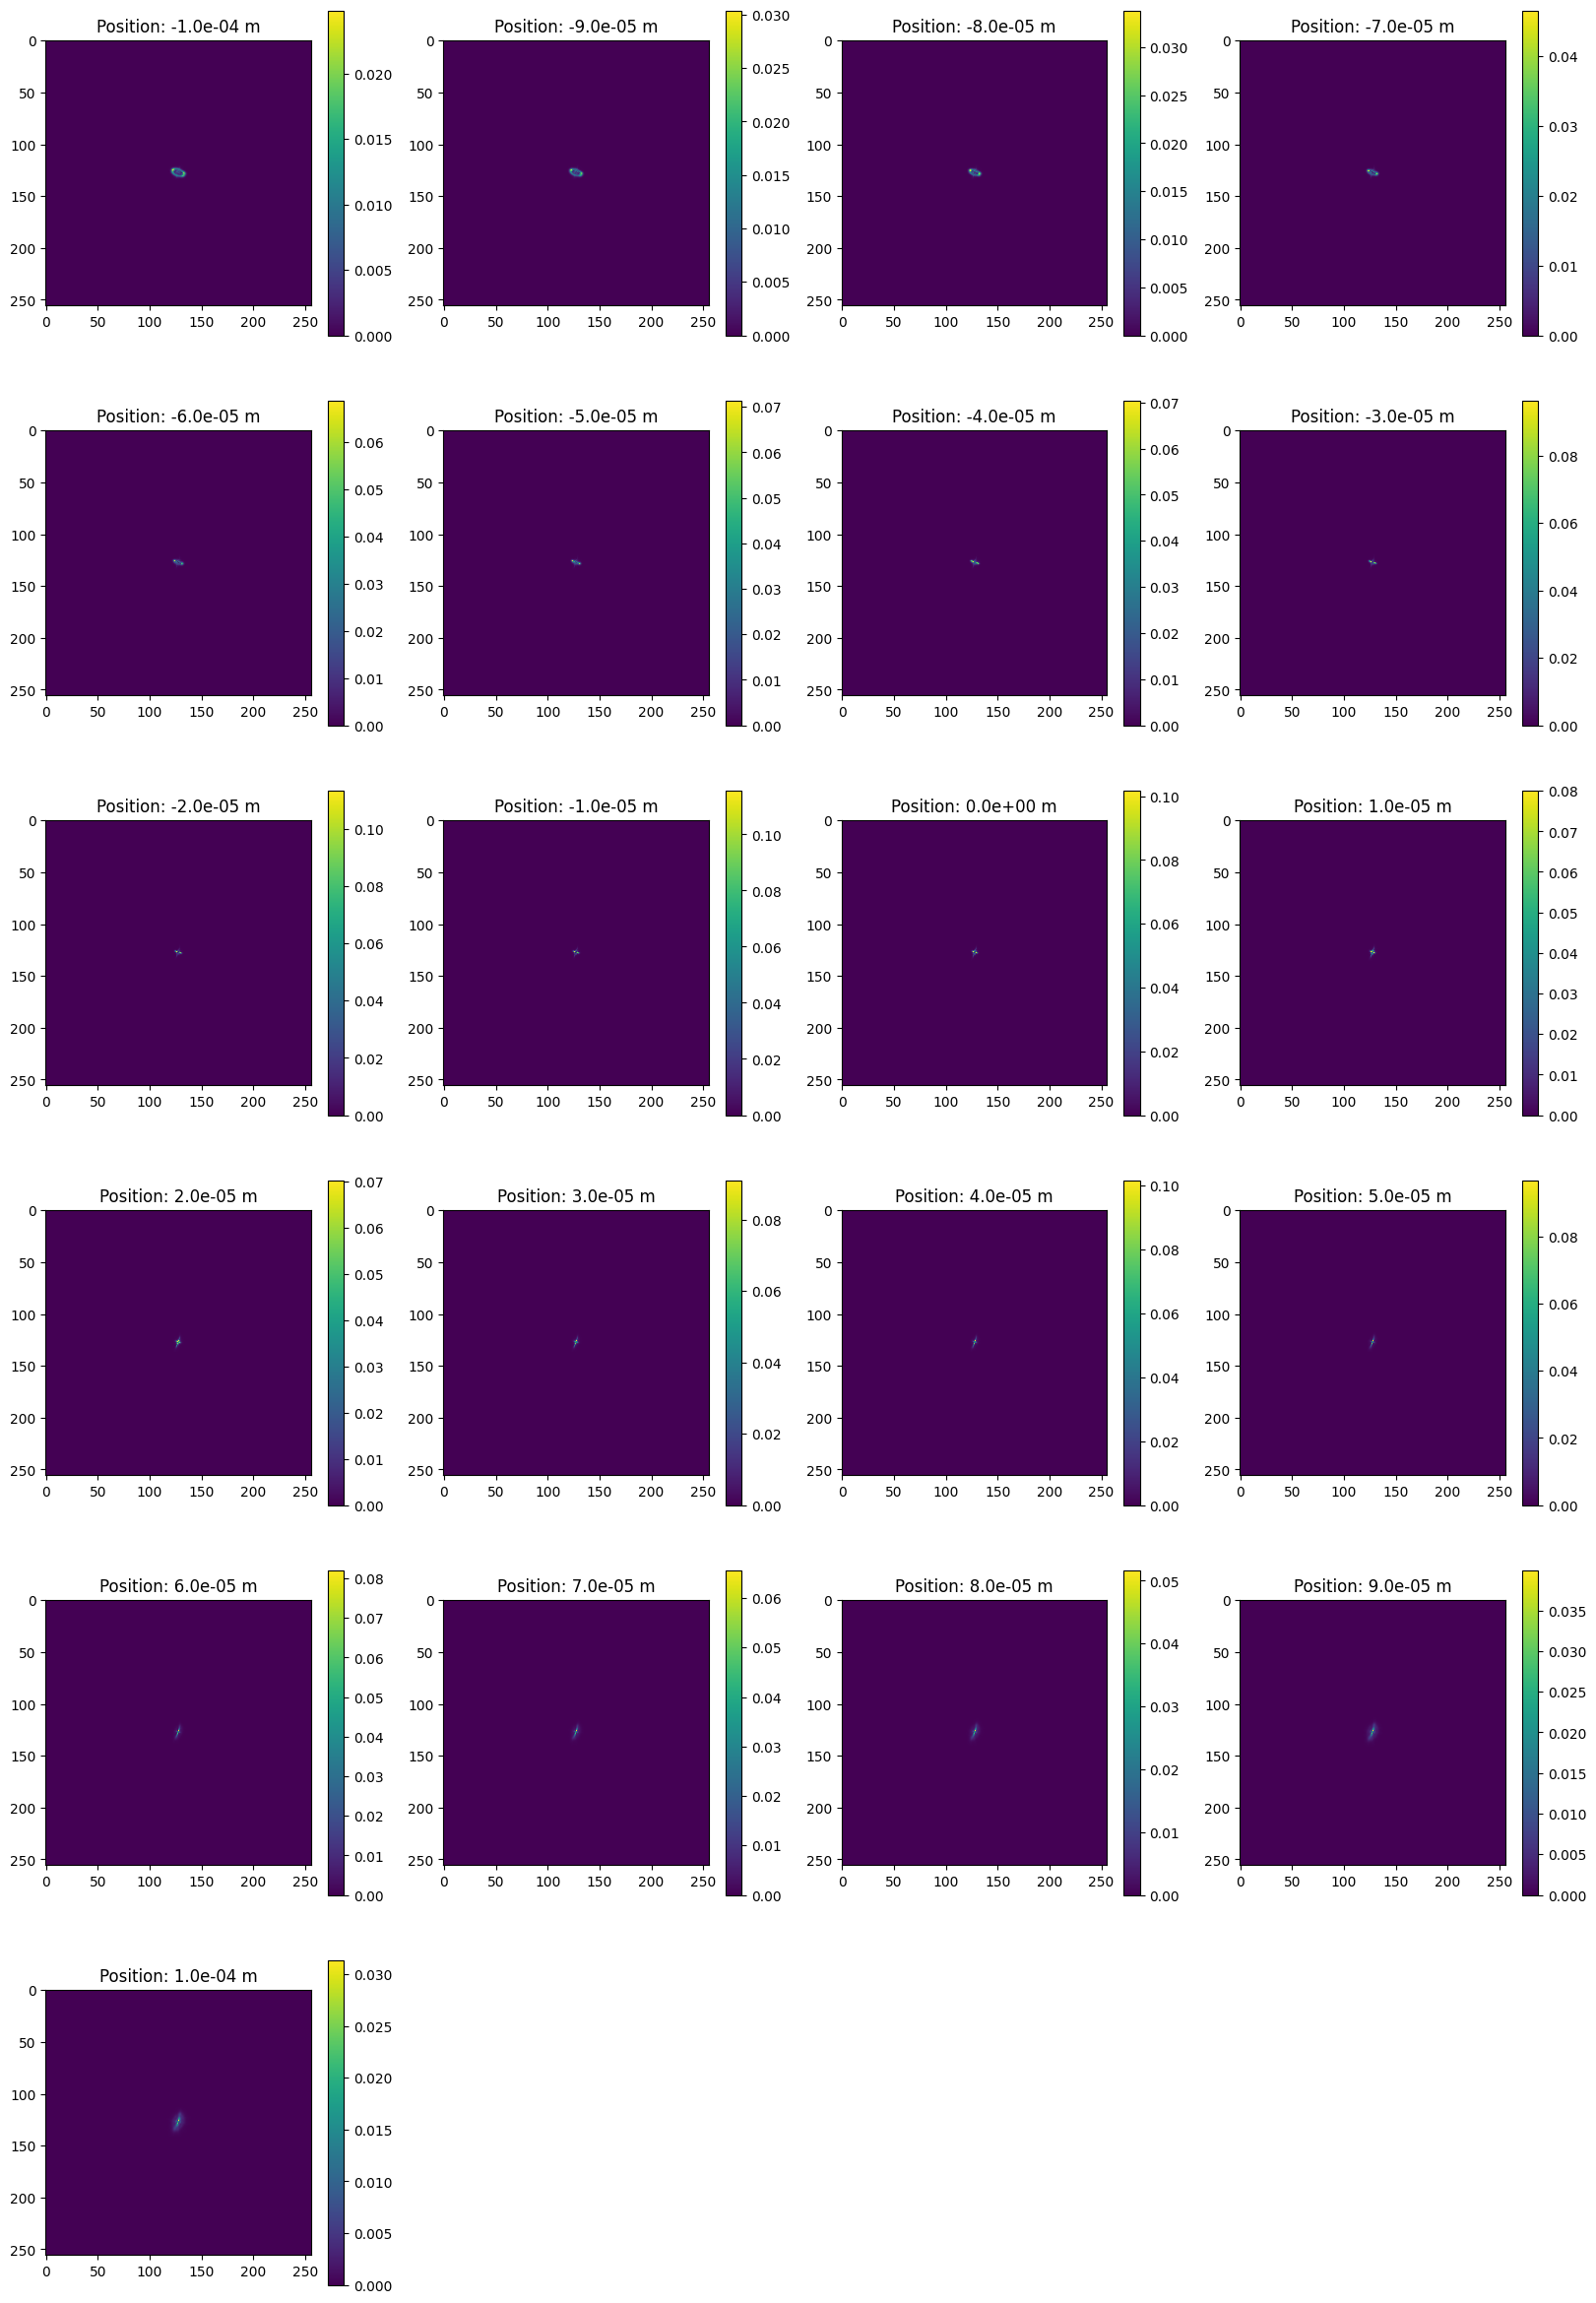

In [10]:
image_raw = np.load('C:/Users/yiyan/OneDrive/Desktop/broadband/sensor_irradiance_bw=500nm.npy')
print(image_raw.shape) # data shape

# Image padding
psf_rows = image_raw.shape[1]
psf_cols = image_raw.shape[2]
upper_padding = round((npix_pupil - psf_rows) / 2)
lower_padding = npix_pupil - psf_rows - upper_padding
left_padding = round((npix_pupil - psf_cols) / 2)
right_padding = npix_pupil - psf_cols - left_padding
image = np.pad(image_raw, pad_width=((0, 0), (upper_padding, lower_padding), (left_padding, right_padding)), mode='constant', constant_values=0)
print(image.shape)

depth = image.shape[0] # image layer
col_num = 4 # column number of images for display
row_num = math.ceil(depth / col_num) # row number of images for display

position = np.load('C:/Users/yiyan/OneDrive/Desktop/broadband/distances.npy')
print(position.shape)

image = cp.asarray(image)
position = cp.asarray(position)

image_size = 5
plt.figure(figsize=(image_size * col_num, image_size * row_num))
for i in range(depth):
    position_info = position[i]
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(image[i].get())
    plt.title(f'Position: {position_info.get():.1e} m')
    plt.colorbar()

plt.show()


# Give the defocus wavefront


(5, 21, 256, 256)
5


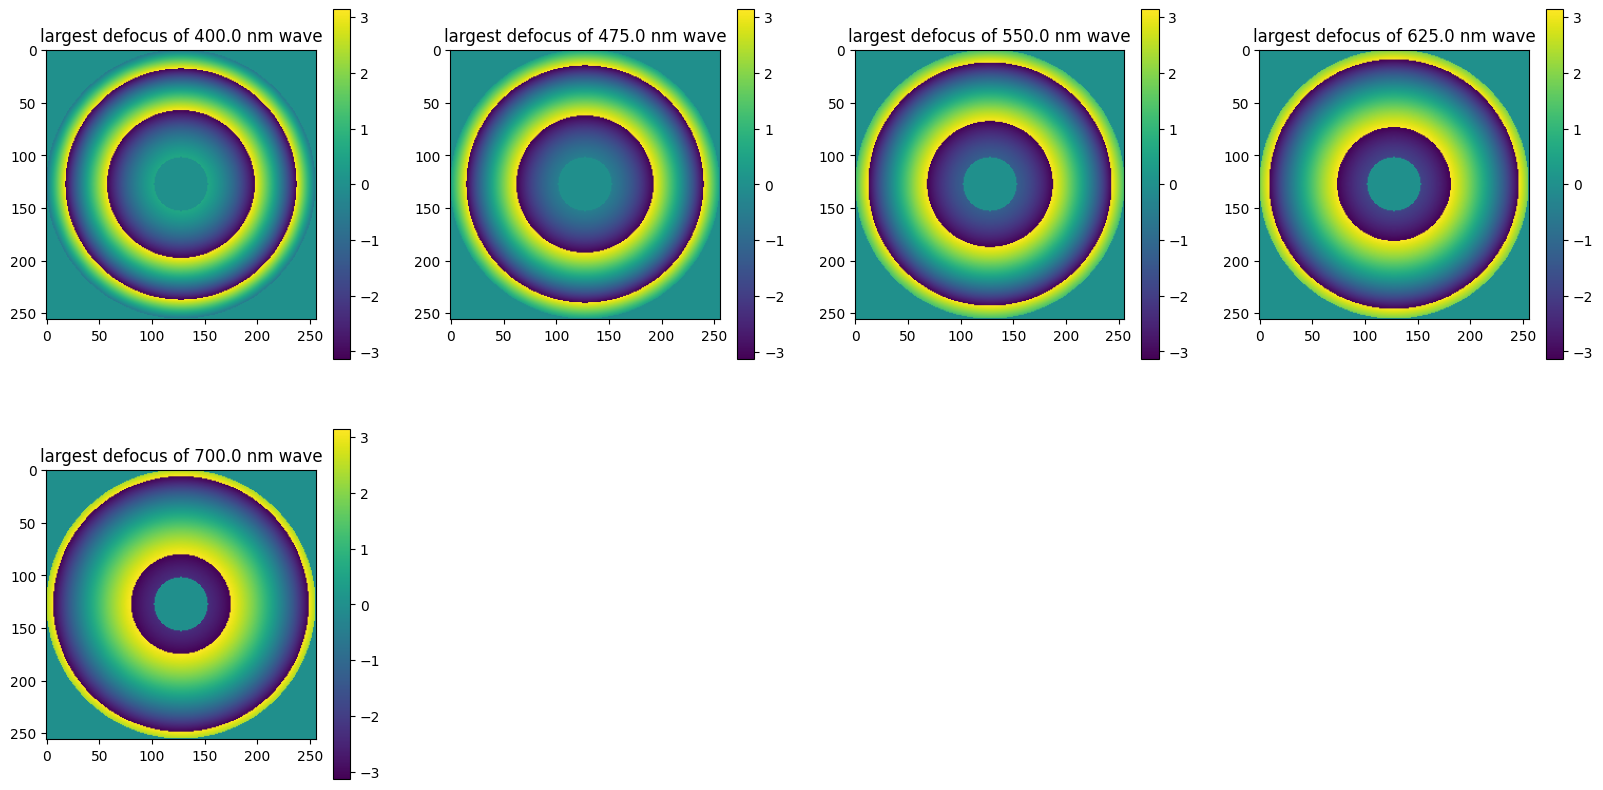

<class 'cupy.ndarray'>


In [30]:
focal_length = 2.537 # focal length in meters

wavelengths = np.linspace(400e-9, 700e-9, 5)  # 5 wavelengths in meters

broadband_probes = [] # initialize a list to store probes for different wavelengths
for wl in wavelengths:
    defocus_values = position/ (8 * wl * (focal_length / od_pupil) ** 2)  # defocus distance is calculated from L = 8Qλ(f/D)^2, so the defocus wave number can be inversely calculated through this
    probes = pr.get_defocus_probes(pupil, defocus_values)
    broadband_probes.append(probes)
broadband_probes = np.stack(broadband_probes, axis=0)
print(broadband_probes.shape) # get the shape of the broad band probes

wave_number = broadband_probes.shape[0] # wavelength layer
print(wave_number)

col_num_wave = 4 # column number of images for display
row_num_wave = math.ceil(wave_number / col_num_wave) # row number of images for display
image_size = 5
plt.figure(figsize=(image_size * col_num_wave, image_size * row_num_wave))
for i in range(wave_number):
    plt.subplot(row_num_wave, col_num_wave, i+1)
    plt.imshow(np.angle(broadband_probes[i,1].get()))
    plt.colorbar()
    wave_info = wavelengths[i] * 1e9
    plt.title(f'largest defocus of {wave_info:} nm wave')

plt.show()
print(type(probes))

# Do phase retrieval


Imeas type: <class 'cupy.ndarray'>
fitmask type: <class 'cupy.ndarray'>
Eprobes type: <class 'cupy.ndarray'>
modes type: <class 'cupy.ndarray'>
<class 'cupy.ndarray'>


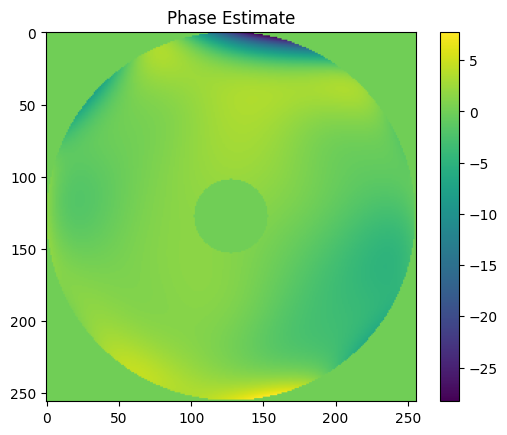

In [88]:
focal_intensities = image
zernikes = pp.zernike.arbitrary_basis(pupil, nterms=45, outside=0) # give the bases of the first 11 zernike polynomials inside 'pupil', and set the data outside the mask to be 0
print("Imeas type:", type(focal_intensities))
print("fitmask type:", type(pupil))
print("Eprobes type:", type(probes))
print("modes type:", type(zernikes))
phase_retrieval_dict = pr.run_phase_retrieval(Imeas=focal_intensities, fitmask=pupil, Eprobes=probes, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False)
print(type(phase_retrieval_dict['fit_params']))
estimated_coeffs = phase_retrieval_dict['fit_params'] # returns in units of radians

# plt.figure()
# plt.plot(np.arange(45) + 1, estimated_coeffs.get() / 2 / np.pi)
# plt.xlabel("Zernike")
# plt.ylabel("Estimated Phase (Waves)")
# plt.show()

np_phase = phase_retrieval_dict['phase_est'].get()
# np.save('phase_estimate.npy', np_phase)
plt.imshow(phase_retrieval_dict['phase_est'].get())
plt.colorbar()
plt.title('Phase Estimate')
# plt.savefig('Phase Estimate.png')
plt.show()


# Data test for Zernike terms

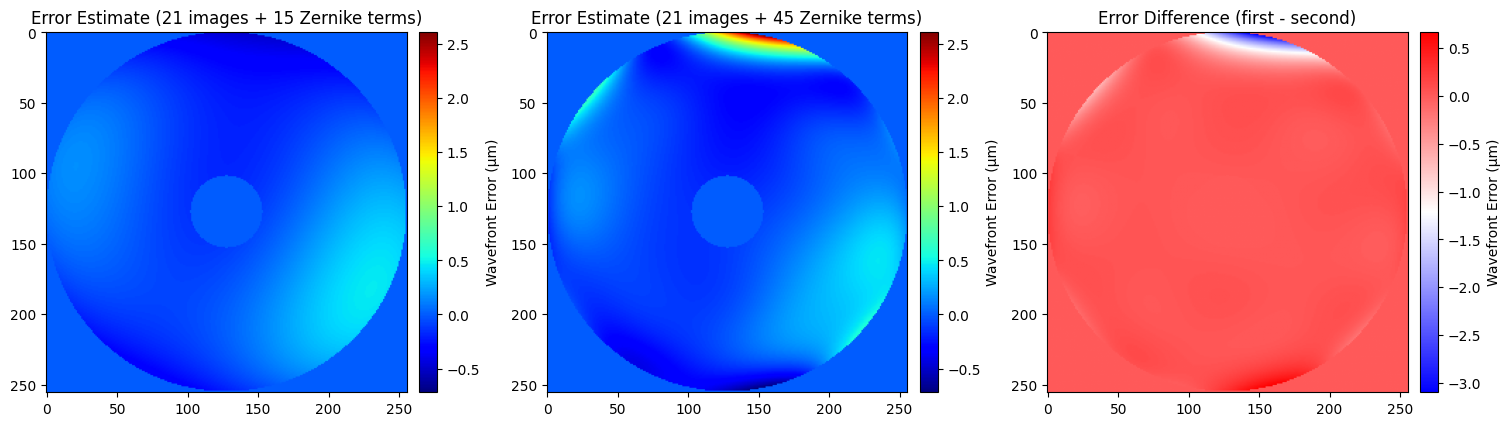

In [98]:
zernikes = pp.zernike.arbitrary_basis(pupil, nterms=15, outside=0) # fit by 15 terms of Zernike polynomials
phase_retrieval_dict = pr.run_phase_retrieval(Imeas=focal_intensities, fitmask=pupil, Eprobes=probes, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False)
np_phase1 = phase_retrieval_dict['phase_est'].get()
np_wavefront1 = np_phase1 * wavelength / (-2 * np.pi) * 1e6 # wavefront error in μm
np.save('wavefront_estimate_zernike15_psf21_bw500nm.npy', np_wavefront1)

zernikes = pp.zernike.arbitrary_basis(pupil, nterms=45, outside=0) # fit by 45 terms of Zernike polynomials
phase_retrieval_dict = pr.run_phase_retrieval(Imeas=focal_intensities, fitmask=pupil, Eprobes=probes, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False)
np_phase2 = phase_retrieval_dict['phase_est'].get()
np_wavefront2 = np_phase2 * wavelength / (-2 * np.pi) * 1e6 # wavefront error in μm
np.save('wavefront_estimate_zernike45_psf21_bw500nm.npy', np_wavefront2)

phase_difference = np_phase1 - np_phase2 # phase difference
wavefront_difference = np_wavefront1 - np_wavefront2

vmin = min(np_wavefront1.min(), np_wavefront2.min())
vmax = max(np_wavefront1.max(), np_wavefront2.max())
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
im1 = axes[0].imshow(np_wavefront1, cmap='jet', vmin=vmin, vmax=vmax)
axes[0].set_title('Error Estimate (21 images + 15 Zernike terms)')
cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.05, pad=0.02)
cbar1.set_label("Wavefront Error (μm)")
im2 = axes[1].imshow(np_wavefront2, cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_title('Error Estimate (21 images + 45 Zernike terms)')
cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.02)
cbar2.set_label("Wavefront Error (μm)")
im3 = axes[2].imshow(wavefront_difference, cmap='bwr')
axes[2].set_title('Error Difference (first - second)')
cbar3 = fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.05, pad=0.02)
cbar3.set_label("Wavefront Error (μm)")
plt.savefig("zernike terms 15 vs 45 - bw 500nm.png", dpi=300, bbox_inches='tight')
plt.show()

# Data test for selected frames

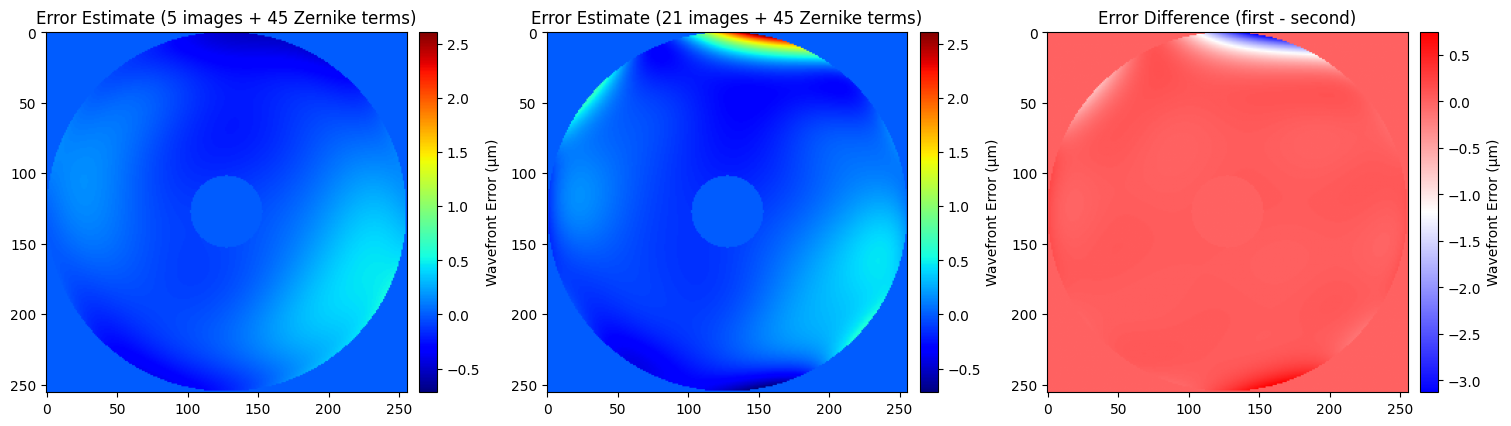

In [99]:
selected_frames = [0, 5, 10, 15, 20]  # indices of selected frames
focal_intensities_subset = focal_intensities[selected_frames]
probes_subset = probes[selected_frames]

zernikes = pp.zernike.arbitrary_basis(pupil, nterms=45, outside=0)
phase_retrieval_dict = pr.run_phase_retrieval(Imeas=focal_intensities_subset, fitmask=pupil, Eprobes=probes_subset, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False)
np_phase1 = phase_retrieval_dict['phase_est'].get()
np_wavefront3 = np_phase1 * wavelength / (-2 * np.pi) * 1e6 # wavefront error in μm
np.save('wavefront_estimate_zernike45_psf5_bw500nm.npy', np_wavefront3)

zernikes = pp.zernike.arbitrary_basis(pupil, nterms=45, outside=0)
phase_retrieval_dict = pr.run_phase_retrieval(Imeas=focal_intensities, fitmask=pupil, Eprobes=probes, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False)
np_phase2 = phase_retrieval_dict['phase_est'].get()
np_wavefront4 = np_phase2 * wavelength / (-2 * np.pi) * 1e6 # wavefront error in μm

phase_difference = np_phase1 - np_phase2 # phase difference
wavefront_difference = np_wavefront3 - np_wavefront4

vmin = min(np_wavefront3.min(), np_wavefront4.min())
vmax = max(np_wavefront3.max(), np_wavefront4.max())
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
im1 = axes[0].imshow(np_wavefront3, cmap='jet', vmin=vmin, vmax=vmax)
axes[0].set_title('Error Estimate (5 images + 45 Zernike terms)')
cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.05, pad=0.02)
cbar1.set_label("Wavefront Error (μm)")
im2 = axes[1].imshow(np_wavefront4, cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_title('Error Estimate (21 images + 45 Zernike terms)')
cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.02)
cbar2.set_label("Wavefront Error (μm)")
im3 = axes[2].imshow(wavefront_difference, cmap='bwr')
axes[2].set_title('Error Difference (first - second)')
cbar3 = fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.05, pad=0.02)
cbar3.set_label("Wavefront Error (μm)")
plt.savefig("psf images 5 vs 21 - bw 500nm.png", dpi=300, bbox_inches='tight')
plt.show()